<a href="https://drive.google.com/file/d/1b7tSyJBpWggHEBGdWa80JdKh7VNq2FEf/view?usp=sharing" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Problem 1
Implement serial test and apply to a `samples`

In [5]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

k = 20

def rng(m=2**32, a=1103515245, c=12345):
    rng.current = (a * rng.current + c) % m
    return rng.current / m
rng.current = 1

samples = np.array([rng() for _ in range(1000)])
n = len(samples) // 2 * 2
data = samples[:n].reshape(-1, 2)
hist = np.histogramdd(data, bins=[np.linspace(0, 1, k+1)]*2)[0]
expected = np.full(hist.shape, np.sum(hist) / np.prod(hist.shape))    
print(stats.chisquare(hist.ravel(), expected.ravel()))

Power_divergenceResult(statistic=np.float64(391.2), pvalue=np.float64(0.6003664860752091))


### Problem 2*
Implement permutation test and apply to a `samples`

In [2]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

def rng(m=2**32, a=1103515245, c=12345):
    rng.current = (a * rng.current + c) % m
    return rng.current / m
rng.current = 1

def permutation_test(samples, d):
    n = len(samples) // d * d
    data = samples[:n].reshape(-1, d)
    sorted_indices = np.argsort(data, axis=1)
    unique_permutations, counts = np.unique(sorted_indices, axis=0, return_counts=True)
    expected = np.full(len(unique_permutations), np.sum(counts) / len(unique_permutations))
    return stats.chisquare(counts, expected)

print(permutation_test(np.array([rng() for _ in range(1000)]), 4))

Power_divergenceResult(statistic=np.float64(22.64), pvalue=np.float64(0.48194973543642283))


### Problem 3

Provide a statistical test to show that `rng_bad` has problems but `rng_good` does not.

In [13]:
def rng_bad(m=2**31, a=65539, c=0):
    rng_bad.current = (a * rng_bad.current + c) % m
    return rng_bad.current / m
rng_bad.current = 1

random_bad = np.array([rng_bad() for _ in range(30000)])
random_good = np.array([rng() for _ in range(30000)])

k = 20
f_obs_bad = np.histogram(random_bad, np.linspace(0, 1, k+1))[0]
f_exp_bad = np.full(k, len(random_bad) // k)
chi2_bad, p_bad = stats.chisquare(f_obs_bad, f_exp_bad)

f_obs_good = np.histogram(random_good, np.linspace(0, 1, k+1))[0]
f_exp_good = np.full(k, len(random_good) // k)
chi2_good, p_good = stats.chisquare(f_obs_good, f_exp_good)

print(f"Chi-square test for rng_bad: chi2 = {chi2_bad:.2f}, p-value = {p_bad:.5f}")
print(f"Chi-square test for rng_good: chi2 = {chi2_good:.2f}, p-value = {p_good:.5f}")


Chi-square test for rng_bad: chi2 = 30.39, p-value = 0.04705
Chi-square test for rng_good: chi2 = 8.99, p-value = 0.97368


### Problem 4
Simulate a sample of 1000 from a discrete distribution on a set of digits $0, 1, 2, \ldots, 9$ with weights $0.12, 0.3, 0.167, 0.24, 0.31, 0.54, 0.111, 0.02, 0.001, 0.2$. Construct a histogram from the sample. Optimise the algorithm by ordering the weights.

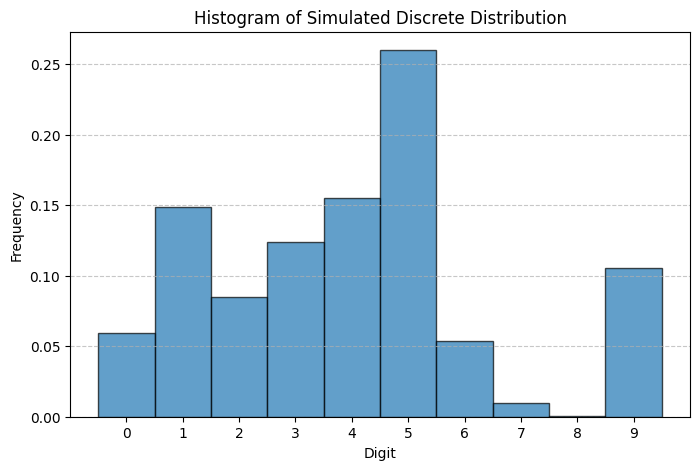

In [42]:
import numpy as np
import matplotlib.pyplot as plt

def generate_weighted_sample(size):    
    digits = np.arange(10)
    weights = np.array([0.12, 0.3, 0.167, 0.24, 0.31, 0.54, 0.111, 0.02, 0.001, 0.2])
    sorted_indices = np.argsort(weights)[::-1]
    sorted_digits = digits[sorted_indices]
    sorted_weights = weights[sorted_indices]
    sample = np.random.choice(sorted_digits, size=size, p=sorted_weights/sorted_weights.sum())
    return sample

sample = generate_weighted_sample(10000)

plt.figure(figsize=(8, 5))
plt.hist(sample, bins=np.arange(-0.5, 10.5, 1), density=True, alpha=0.7, edgecolor='black')
plt.xlabel('Digit')
plt.ylabel('Frequency')
plt.title('Histogram of Simulated Discrete Distribution')
plt.xticks(np.arange(10))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


### Problem 5
Simulate a sample of size 1000 from the distribution $\operatorname{Exp}(\lambda)$ using the Inverse transform method. Construct a sample histogram and an accurate plot of the distribution density.

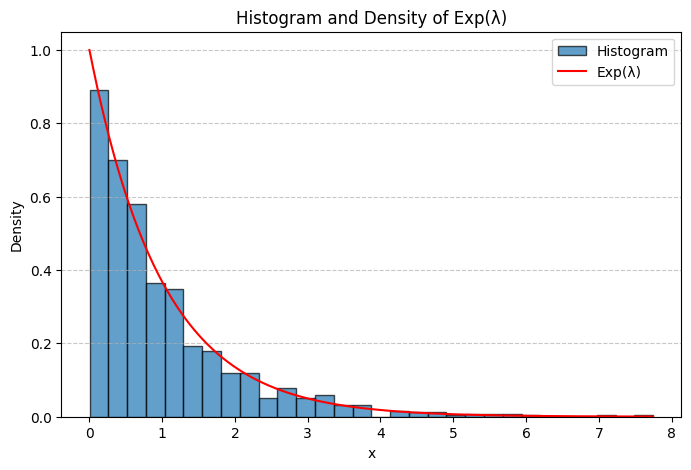

In [44]:
import numpy as np
import matplotlib.pyplot as plt

def inverse_transform_exponential(lambda_param, size):
    uniform_samples = np.random.rand(size)
    exp_samples = -np.log(1 - uniform_samples) / lambda_param
    return exp_samples

lambda_param = 1.0
sample = inverse_transform_exponential(lambda_param, 1000)

x = np.linspace(0, max(sample), 1000)
y = lambda_param * np.exp(-lambda_param * x)
plt.figure(figsize=(8, 5))
plt.hist(sample, bins=30, density=True, alpha=0.7, edgecolor='black', label='Histogram')
plt.plot(x, y, 'r-', label='Exp(λ)')
plt.xlabel('x')
plt.ylabel('Density')
plt.title('Histogram and Density of Exp(λ)')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


### Problem 6
Justify (orally) that the accept-reject method really samples from the required distribution. Simulate $1000$ points from the distribution with density $e^xcos^2x \cdot \mathbb{I}_{[-\frac\pi2, \frac\pi2]}$. Plot the sampled histogram on the sample and compare it with the plot of the exact density function.

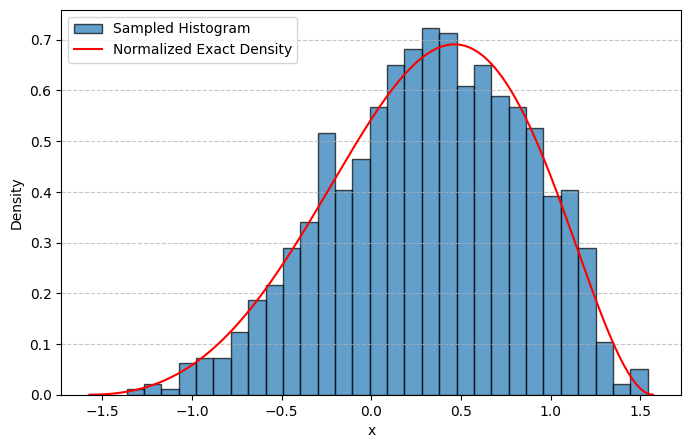

In [24]:
import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt

def f(x):
    return (np.exp(x) * (np.cos(x) ** 2))

def f_density(x):
    return f(x) / integrate.quad(f, -np.pi / 2, np.pi / 2)[0]

def rejection_sampling():
    sample = []
    counter = 0
    
    while counter < 1000:
        current = -np.pi / 2 + np.random.uniform(0, 1) * np.pi
        if np.random.uniform(0, 10 / np.pi) <= f_density(current):
            sample.append(current) 
            counter += 1
    
    return sample

sample = rejection_sampling()
x = np.linspace(-np.pi/2, np.pi/2, 1000)
density = np.exp(x) * np.cos(x) ** 2

plt.figure(figsize=(8, 5))
plt.hist(sample, bins=30, density=True, alpha=0.7, edgecolor='black', label='Sampled Histogram')
plt.plot(x, density / np.trapezoid(density, x), 'r-', label='Normalized Exact Density')
plt.xlabel('x')
plt.ylabel('Density')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### Problem 7
Model and depict a sample of 500 points uniformly distributed within a given triangle without using a selection method.

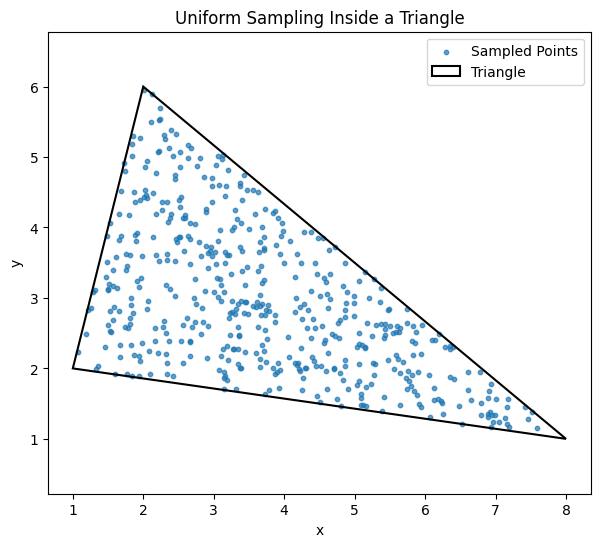

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def sample_from_triangle(v1, v2, v3, size):    
    u = np.random.rand(size, 1)
    v = np.random.rand(size, 1)
    u, v = np.where(u + v > 1, 1 - u, u), np.where(u + v > 1, 1 - v, v)
    return (1 - u - v) * v1 + u * v2 + v * v3

v1, v2, v3 = np.array([1, 2]), np.array([2, 6]), np.array([8, 1])
sample = sample_from_triangle(v1, v2, v3, 500)

plt.figure(figsize=(7, 6))
plt.scatter(sample[:, 0], sample[:, 1], s=10, alpha=0.7, label='Sampled Points')
plt.fill([v1[0], v2[0], v3[0]], [v1[1], v2[1], v3[1]], edgecolor='black', fill=False, linewidth=1.5, label='Triangle')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Uniform Sampling Inside a Triangle')
plt.legend()
plt.axis('equal')
plt.show()

### Problem 8
Model without using the selection method a sample of $500$ points uniformly distributed inside the unit circle. Picture the obtained points. Do they really fill the circle uniformly?

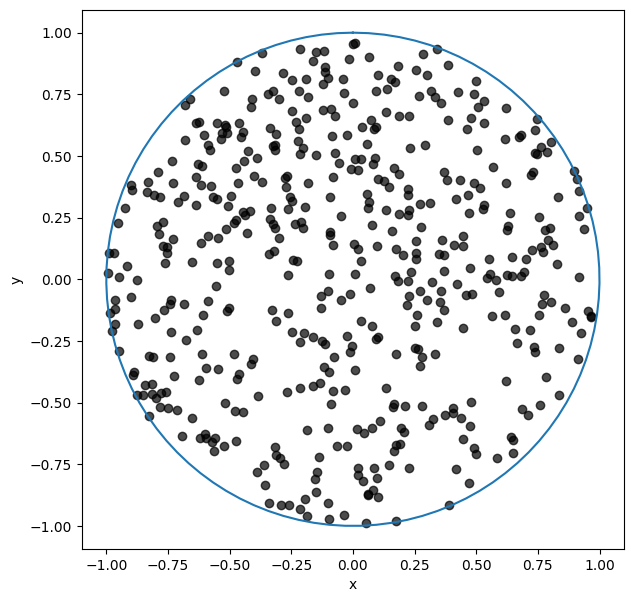

In [52]:
import numpy as np
import matplotlib.pyplot as plt

def sample_from_unit_circle(size):
    r = np.sqrt(np.random.rand(size))
    t = 2 * np.pi * np.random.rand(size)
    x = r * np.sin(t)
    y = r * np.cos(t)
    return np.column_stack((x, y))

sample = sample_from_unit_circle(500)

plt.figure(figsize=(7, 7))
plt.scatter(sample[:, 0], sample[:, 1], color="black", alpha=0.7)
t = np.linspace(0, 2*np.pi, 100)
plt.plot(np.sin(t), np.cos(t))
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')
plt.show()


### Problem 9
Prove (orally) that the following algorithm (**Box-Muller algorithm**, https://en.wikipedia.org/wiki/Box%E2%80%93Muller_transform) generates a sample of independent $\mathcal{N}(0,1)$ random variables. Modify the method to exclude calls of trigonometric functions `np.sin` and `np.cos`. Using the modified method, simulate a sample size of $1000$ from a $2D$ Gaussian distribution with mean $\mu$ and covariance matrix $\Sigma$, where
$$\mu = \begin{pmatrix} 4 \\ 7 \end{pmatrix}^T, \quad \Sigma = \begin{pmatrix} 20 & -4 \\ -4 & 40 \end{pmatrix}.$$
Construct a 2D histogram of the resulting distribution. Compare the sample mean and covariance matrix with the exact values.

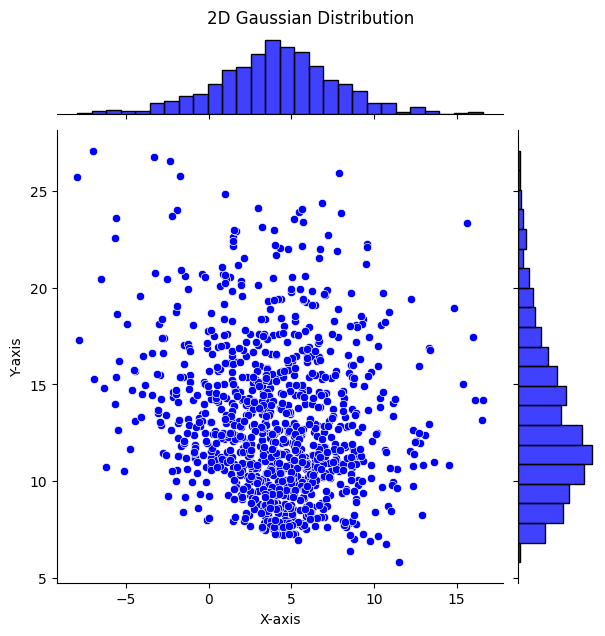

Sample mean: [ 4.08973158 13.01212043]
Sample covariance matrix:
[[14.18155521 -2.37716712]
 [-2.37716712 14.96461761]]


In [26]:
import seaborn as sns

def box_muller_transform(n):
    u1, u2 = np.random.rand(2, n)
    r = np.sqrt(-2 * np.log(u1))
    x = 2 * u2 - 1
    y = np.sqrt(1 - x**2)
    return np.column_stack((r * x, r * y))

n = 1000
samples_standard = box_muller_transform(n)
mu = np.array([4, 7])
Sigma = np.array([[20, -4], [-4, 40]])
L = np.linalg.cholesky(Sigma)
samples_gaussian = samples_standard @ L.T + mu
sample_mean = np.mean(samples_gaussian, axis=0)
sample_cov = np.cov(samples_gaussian, rowvar=False)
joint_plot = sns.jointplot(x=samples_gaussian[:, 0], y=samples_gaussian[:, 1], color="blue")
joint_plot.set_axis_labels('X-axis', 'Y-axis')
plt.suptitle('2D Gaussian Distribution', y=1.02)
plt.show()

print(f"Sample mean: {sample_mean}")
print(f"Sample covariance matrix:\n{sample_cov}")

### Problem 10*

Implement a method of generating a random partition of an n-element set into subsets. Use it to estimate the expected number of subsets in a random partition of a set of 100 elements.

Hint 1: Ширяев, Вероятность, т1, задача 2 к параграфу 1.

Hint 2: http://djalil.chafai.net/blog/2012/05/03/generating-uniform-random-partitions/

In [ ]:
# Your code here

# Basic distributions
- **Uniform distribution $\operatorname{U}[a, b]$**:
$$p(x) = \frac{1}{b-a}\cdot\mathbb{I}_{x\in[a, b]}$$

- **Exponential distribution $\operatorname{Exp}(\lambda)$**:
$$p(x) = \lambda e^{-\lambda x}\cdot\mathbb{I}_{x\geqslant0}$$

- **Normal distribution $\mathcal{N}(\mu, \sigma^2)$**:
$$p(x) = \frac{1}{\sqrt{2\pi}\sigma}e^{-\frac{(x-\mu)^2}{2\sigma^2}}$$

- **Gamma distribution $\operatorname{Gamma}(\alpha, \lambda)$**:
$$p(x) = \frac{\lambda^\alpha}{\Gamma(\alpha)}x^{\alpha-1}e^{-\lambda x}\cdot\mathbb{I}_{x\geqslant0}$$

- **Beta distribution $\operatorname{Beta}(\alpha, \beta)$**:
$$p(x) = \frac{\Gamma(\alpha+\beta)}{\Gamma(\alpha)\Gamma(\beta)}x^{\alpha-1}(1-x)^{\beta-1}\cdot\mathbb{I}_{x\in[0, 1]}$$

- **$\chi^2$ distribution with $k$ degrees of freedom $\chi^2(k)$**:
$$p(x) = \frac{1}{2^{k/2}\Gamma(k/2)}x^{k/2-1}e^{-x/2}\cdot\mathbb{I}_{x\geqslant0}$$



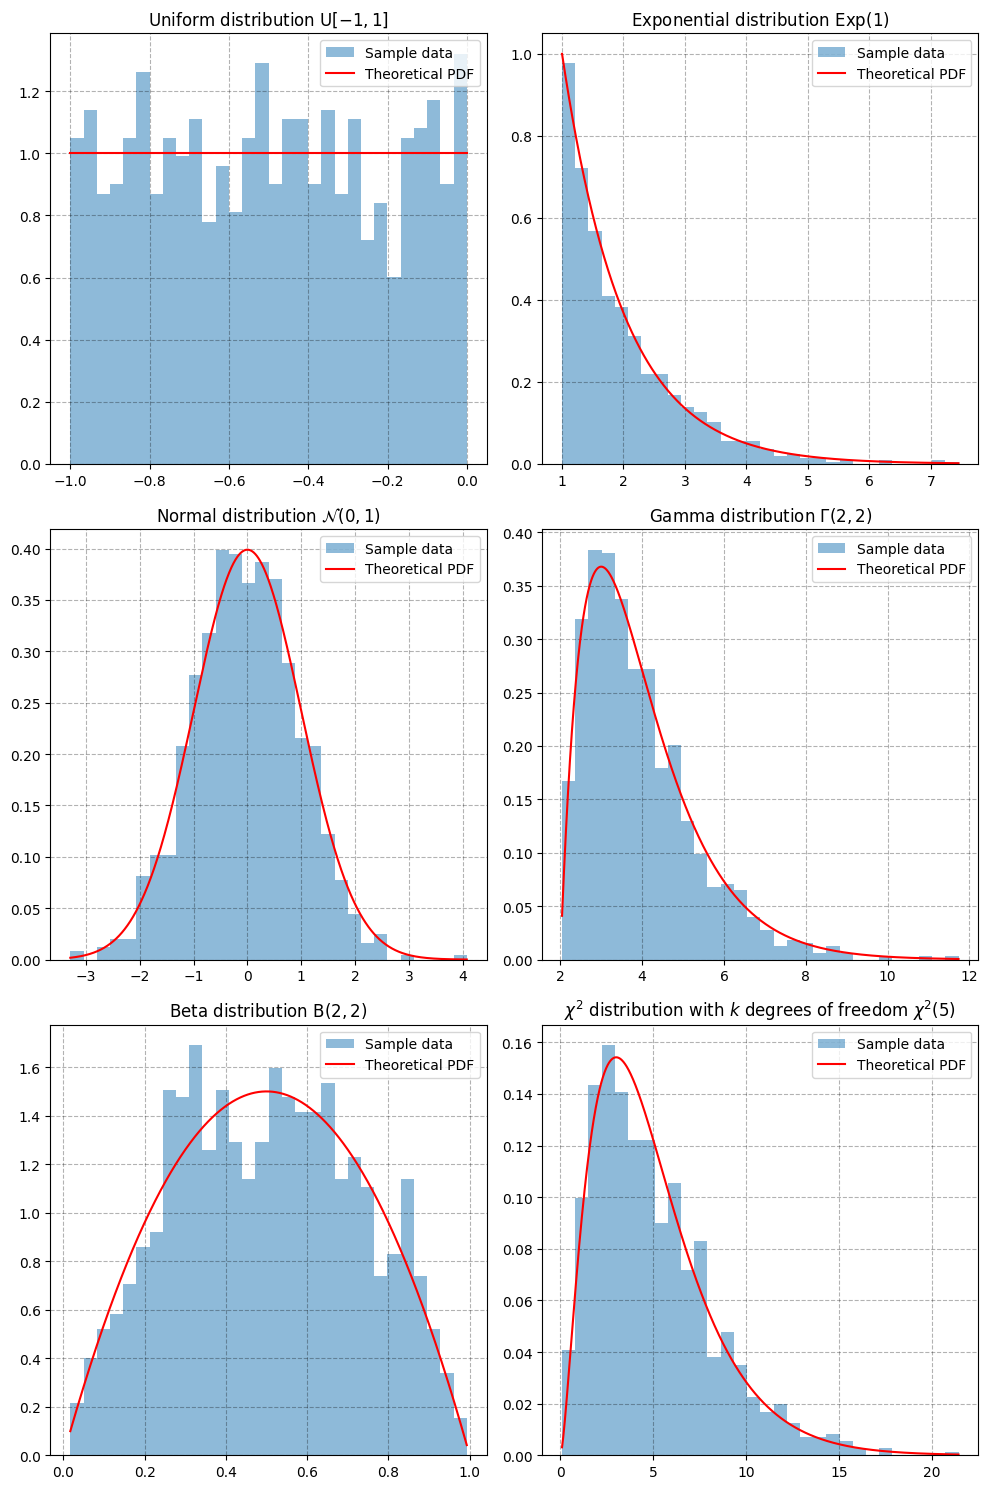

In [ ]:
# Define distributions and their parameters
distributions = [
    ("Uniform distribution $\\operatorname{U}[-1, 1]$", stats.uniform, (-1, 1)),
    ("Exponential distribution $\\operatorname{Exp}(1)$", stats.expon, (1,)),
    ("Normal distribution $\\mathcal{N}(0, 1)$", stats.norm, (0, 1)),
    ("Gamma distribution $\\Gamma(2, 2)$", stats.gamma, (2, 2)),
    ("Beta distribution $\\operatorname{B}(2, 2)$", stats.beta, (2, 2)),
    ("$\\chi^2$ distribution with $k$ degrees of freedom $\\chi^2(5)$", stats.chi2, (5,))
]

# Setup the figure and axes for a 2x3 subplot
fig, axs = plt.subplots(3, 2, figsize=(10, 15))  # Adjust figsize according to your needs
axs = axs.flatten()  # Flatten the array to easily iterate over it

for ax, (name, dist, params) in zip(axs, distributions):
    # Generate sample data
    data = dist.rvs(*params, size=1000)
    # Generate points for PDF
    x = np.linspace(min(data), max(data), 1000)
    pdf = dist.pdf(x, *params)

    # Plot histogram of sample data
    ax.hist(data, bins=30, density=True, alpha=0.5, label='Sample data')
    # Plot theoretical PDF
    ax.plot(x, pdf, 'r-', label='Theoretical PDF')
    ax.set_title(name)
    ax.legend()
    ax.grid(linestyle='--', color='black', alpha=0.3)

plt.tight_layout()  # Adjust subplots to fit in the figure area
plt.show()
